# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import json
import logging
from pathlib import Path
from time import perf_counter_ns as timer
from uuid import uuid4

from pandas import DataFrame
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS

In [2]:
def print_table(rows, title: str | None = None):
    table = Table(*[k for k in rows[0]], title=title, box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
project_path = Path("../")
datasets_path = project_path / ".build" / "datasets"

logger = logging.getLogger(__name__)

# Parameters

In [4]:
# Provider config
providers = {
    "ollama": {
        "model": "llama3.2:3b-instruct-fp16",
        "options": {
            "num_predict": 10,  # Limit output tokens to avoid waiting for invalid responses
            "top_k": 1,  # Disable token sampling
        },
        "generator_factory": lmb.models.ollama,
    },
    "openai": {
        "model": "gpt-4o-mini",
        "options": {
            "max_tokens": 10,  # Limit output tokens to avoid waiting for invalid responses
            "temperature": 0,  # Disable token sampling
        },
        "generator_factory": lmb.models.openai,
    },
}

# Selected provider
provider = "openai"

In [5]:
# Number of iterations
n_epochs = 10

# Number of questions to sample
n_questions = 160

# Number of parallel requests
n_jobs = 3

# Demonstrate Bias

In [6]:
# Load example questions
examples = lmb.datasets.mmlu.load_dataset(datasets_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.normalize_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(datasets_path, segment="test")

# Initialize thread pool
executor = ThreadPoolExecutor(max_workers=n_jobs)

# Create generator from provider
generator_factory = providers[provider]["generator_factory"]
model = providers[provider]["model"]
options = providers[provider]["options"]
generator = partial(generator_factory, model=model, options=options)

print(f"Configured {provider} provider: {model}, {options}")

Configured openai provider: gpt-4o-mini, {'max_tokens': 10, 'temperature': 0}


In [7]:
def process_mcq(mcq):
    # Generate prompt
    prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

    # Generate answer
    response = generator(prompt=prompt)

    # Evaluate response
    return lmb.datasets.mmlu.evaluate_response(mcq, response)


def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
):
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question
    futures = [executor.submit(process_mcq, mcq) for _, mcq in questions.iterrows()]

    # Collect results
    correct, errors = 0, 0
    for future in tqdm(as_completed(futures), total=n, desc=description):
        evaluation = future.result()
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

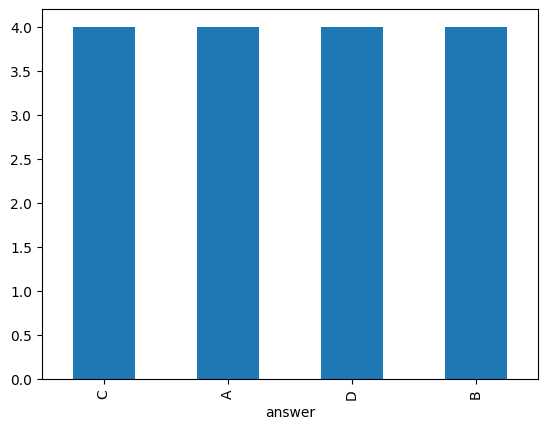

In [8]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.normalize_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [9]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about high school chemistry.

Example Question: A new compound is synthesized and found to be a monoprotic acid with a molar mass of 248 g/mol. When 0.0050 mol of this acid are dissolved in 0.500 L of water, the pH is measured as 3.89. What is the pKa of this acid?

A) 3.89
B) 7.78
C) 5.78
D) 2.33

Example Answer: {"answer": "C"}

Example Question: A solution contains 2.00 mole of acetic acid, CH3COOH, and 1.00 mole of calcium acetate, Ca(CH3COO)2. The solution is able to resist the addition of a small amount of strong acid or strong base with only minor changes in the pH of the solution. Larger quantities of strong acid or strong base can cause a significant change in pH. How many moles of nitric acid, HNO3, may be added before the pH begins to change significantly?

A) 2.00 mole
B) 1.00 mole
C) 0.500 mole
D) 3.00 mole

Example Answer: {"an

In [10]:
%%time

rows = []
for i in range(3):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
    )

    rows.append(metrics)

print_table(rows)

epoch 0:   0%|                                                                                                                                                      | 0/16 [00:00<?, ?it/s]stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
epoch 0:   0%|                                                                                                                                                      | 0/16 [00:34<?, ?it/s]


KeyboardInterrupt: 

stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_sc

## Estimate Positional Bias

In [11]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.normalize_question_answers(
        selected_questions
    )

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["uniform"] = benchmark(
        "uniform",
        examples=examples,
        questions=selected_questions,
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
        )

    rows.append(metrics)

uniform:   0%|                                                                                                                                                     | 0/160 [31:50<?, ?it/s]


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [12]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

 uniform   A   B   C   D  
 ─────────────────────────

# Export Results

In [13]:
path = Path(f"results/demonstrate-bias-{model}-{n_questions}-{n_epochs}-{uuid4().hex}.json")
path.write_text(json.dumps(rows))

2